# Lifecycle
* This notebook implements the second part of lifecycle process i.e Feature Engineering.
* Following is the list of lifecycle processes.
    * Data Analysis or EDA
    * **Feature Engineering** (Content of this notebook)
    * Feature Selection
    * Pipelining
    * Model Selection and Building
    * Model Deployment
* All these are performed on a very famous kaggle competition known as House Price Prediction.

# Feature Engineering
* This is the second step after Exploratory Data Analysis.
* Check out my notebook on Exploratory Data Analysis for the House Price Prediction competition.
* Now, let's continue with feature engineering

## Definition
* It is the process selecting, manipulating and transforming raw data into features that can be used in supervised learning.
* This also includes adding of some new features (if necessary) derived from combination of two or more features.

## What will we consider in this notebook?
* Handling Missing Values
    * Numerical
    * Categorical
* Handling Temporal Variable
* Handling Outliers
* Removing rare labels
* Performing Encoding for categorical features.
* Log transforming (If necessary)
* Standardizing the values (If necessary).
* Note that after some tinkering, both these steps are not needed because we might be using Tree based model and they are not affected by the distributions and scaling. 

> Since this step will be performed for both trainig as well as test set, it is better to define functions for it.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Read the Dataset
X_train = pd.read_csv("../input/home-data-for-ml-course/train.csv")
X_test = pd.read_csv("../input/home-data-for-ml-course/test.csv")

In [3]:
# Create a copy to ensure that we have a backup
X_train_original = X_train.copy()
X_test_original = X_test.copy()

In [4]:
# Drop the id columns for training data
X_train = X_train.drop("Id", axis = 1)

* Seperate numerical and categorical features
* Further seperate numerical features into continuous and discrete features.

In [5]:
continuous_features = []
discrete_features = []
numerical_features = []
categorical_features = []

for feature in X_train.columns:
    if X_train[feature].dtypes == 'O': # If the datatype is object then it is categorical feature
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)
        if X_train[feature].unique().sum() <= 15: # This threshold is derived from EDA notebook that I published.
            discrete_features.append(feature)
        else:
            continuous_features.append(feature)

# Handling Missing Values
* There are two types of features, one is categorical and one is numerical and the method of handling both of these are different.
* Categorical Features
    * Remove the missing values --> This is a good approach if the number of missing values is very less (<5%) but if the number of missing values are in large amounts (>50%), then this method might fail and give results with high bias.
    * Replace the missing values with mode of the data --> Mode of the data means the observation that occurs maximum number of times. For categorical feature, replacing missing value with mode makes sense because one can't find mean or median or any other statistical measure for it.
    * Replace the missing values with a new label "others" --> This, in my opinion, is the best approach as not only it helps to retain the information but creates a new better variable which might affect the SalePrice as seen in EDA Section.
* Numerical Features
    * For discrete features, replacing the missing values with mode is the best option for obvious reasons.
    * For continuous features
        * Remove the records containing missing values --> This step must be done very carefully as it might result into loss of important information.
        * Replace the missing values with mean --> This is one of the most common steps done. However, there is a problem associated with it. Sometimes, the mean is biased in terms of outliers. They greatly influence the mean and hence this might now be a wise choice if we detect the presence of outliers in EDA part.
        * Replace the missing values with median --> This is the best approach because the median is not affected by outliers. Further, median represents 50th Percentile which means 50% values are above and below that point.
        * Replace the missing values with mode

In [6]:
# Get numerical and categorical features with NaN Values
numerical_features_with_null_values = []
categorical_features_with_null_values = []

for feature in X_train.columns:
    if X_train[feature].isna().sum() > 0 and feature in numerical_features:
        numerical_features_with_null_values.append(feature)
    
    if X_train[feature].isna().sum() > 0 and feature in categorical_features:
        categorical_features_with_null_values.append(feature)

In [7]:
def handle_missing_values(X):
    # Numerical Features
    for feature in numerical_features_with_null_values:
        if feature != "SalePrice":
            X[feature].fillna(X[feature].median(), inplace=True)
        # We choose median because of outliers
        
    # Categorical Features
    for feature in categorical_features_with_null_values:
        X[feature].fillna("Others", inplace=True)
    
    return X

In [8]:
X_train = handle_missing_values(X_train) # Call the function

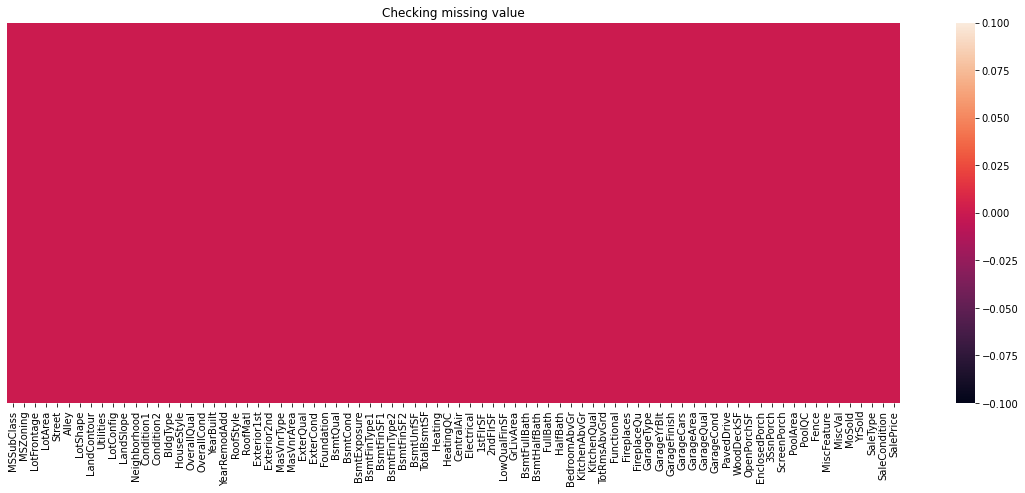

In [9]:
# Verify that there are no missing values
plt.figure(figsize=(20, 7))
sns.heatmap(X_train.isnull(), yticklabels=False)
plt.title("Checking missing value")
plt.show()

### Interpretation
* From the above heatmap, it is clear that there are no missing values remaining in any of the columns.

# Handling Temporal Variables
* The best way to handle temporal variable is to convert it into "age".
* This means that suppose a building was built in 2000 and was sold in 2010, then its age is 10 years.
* This goes for all temporal features.

In [10]:
# Create array for temporal variables
feature_with_year = []

for feature in X_train.columns:
    if "Yr" in feature or "Year" in feature:
        feature_with_year.append(feature)

In [11]:
# For temporal variables, we will change years to "age" meaning how many years old.
def handle_temporal_variable(X):    
    for feature in feature_with_year:
        if feature != "YrSold":
            X[feature] = X["YrSold"] - X[feature]
    return X

In [12]:
X_train = handle_temporal_variable(X_train) # Handled Temporal Variables

# Handling Outliers
* This is the hardest part because of the fact that finding the range beyond which an observation is considered outlier.
* However, a very beautiful article ([link](https://medium.com/analytics-vidhya/how-to-handle-outliers-in-machine-learning-5d8105c708e5#:~:text=To%20impute%20the%20outliers%2C%20we,%2C%20mode%2C%20and%20boundary%20values.&text=Congratulations%20on%20learning%20how%20to,Feature%20Engineering%20on%20the%20data.)) explains it very easily.
* Since, we have not yet transformed the data, the we are using 1.5*IQR (Inter Quartile Range) as the threshold.

In [13]:
def handle_outliers(X):
    for feature in X.columns:
        if X[feature].dtypes != "O":
            q1 = np.percentile(X[feature], 25, interpolation='midpoint')
            median = np.percentile(X[feature], 50, interpolation='midpoint')
            q3 = np.percentile(X[feature], 75, interpolation='midpoint')
            iqr = q3 - q1
            
            upper_limit = (q3 + 1.5*iqr)
            lower_limit = (q1 - 1.5*iqr)
            
            X[feature] = np.where(X[feature] > upper_limit, median, X[feature])
            X[feature] = np.where(X[feature] < lower_limit, median, X[feature])
        
    return X

In [14]:
X_train = handle_outliers(X_train)

# Handling Rare Records for Categorical Features
* I consider "Rare" classes for a categorical feature as those classes whose frequency of occurence is less than 1%.
* We can combine these features into a new label called "Others_R" without the loss of much information and we might get some unexpected improvement in our model.

In [15]:
def handle_rare_classes(X):
    for feature in categorical_features:
        feature_percentage = X.groupby(feature)["SalePrice"].count()*100/len(X)
        feature_less_than_1 = feature_percentage[feature_percentage<1].index
        X[feature] = np.where(X[feature].isin(feature_less_than_1), "Others_R", X[feature])
    return X

In [16]:
X_train = handle_rare_classes(X_train)

# Performing Encoding for Categorical Features
* Most of the models expect a numerical imput in order to train itself and predict for the test data.
* Thus, it makes a requirement for converting the categorical feature into Numercial one.
* One can do this by "encoding" categorical features
* For further reference, read [this article](https://towardsdatascience.com/categorical-feature-encoding-547707acf4e5#:~:text=6.-,Label%20Encoding%20and%20Ordinal%20Encoding,unique%20value%20in%20a%20feature.).

## Types of encoders
* One-Hot encoding
    * Created new columns for each class and assigns them either 0 or 1.
    * Further, it ensures that exactly 1 of the columns have 1 for each observation.
    * This helps in representing the classes required.
* Label Encoding
    * Unlike one-hot encoding, it does not add a column, instead it assigns each class with a number.
* Target Encoding
    * Aligns unique categorical values with the target feature based on the average relationships.
    * So basically, we assign each label its mean of the target variables.
* **Note that here we will be using label encoding.**

In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for feature in categorical_features:
    X_train[feature] = encoder.fit_transform(X_train[feature])
    
# Convert each feature into float64 type
X_train = X_train.astype("float64")

# Easiest way to check whether any is left of not is to use info()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   float64
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   float64
 5   Alley          1460 non-null   float64
 6   LotShape       1460 non-null   float64
 7   LandContour    1460 non-null   float64
 8   Utilities      1460 non-null   float64
 9   LotConfig      1460 non-null   float64
 10  LandSlope      1460 non-null   float64
 11  Neighborhood   1460 non-null   float64
 12  Condition1     1460 non-null   float64
 13  Condition2     1460 non-null   float64
 14  BldgType       1460 non-null   float64
 15  HouseStyle     1460 non-null   float64
 16  OverallQual    1460 non-null   float64
 17  OverallCond    1460 non-null   float64
 18  YearBuil

# Checkpoint
* We have handled almost all types of datatypes.
* These include numerical (discrete and continuous), categorical and temporal features.
* Then we have handled outliers and after handling missing values.
* Further, we have combined rare labels and created a new label called "Others_R"
* At this point, we have **preprocessed** the data to an extent that any model can generate the results.
* However, the work of feature engineering is not yet over.
* We may still scale and transform the data to make it more ideal and align it to a particular distribution (like Gaussian/Normal distribution).
* This helps for the model to improve its performance and in turn its accuracy.

# Log-Transform the data
* Follow [this article](https://towardsdatascience.com/logarithms-what-why-and-how-ff9d050d3fd7) to understand the know hte basics of log transform.
* After understanding what is it and what it does, the main question is what are the features on which log transformation needs to be applied or how to select the features for log-transformation.
* We select those features that are right skewed as the features that require log transformation.
* We further make sure that we don't select those features that have either bimodal or multimodal distribution.
* These are selected based on EDA done previously.

In [18]:
# Selected features
feature_for_log_transform = ['LotFrontage', "LotArea", "1stFlrSF", "GrLivArea"]

# Function to handle
def log_transform(X):
    for feature in feature_for_log_transform:
        X[feature] = np.log1p(X[feature])
    return X

In [19]:
X_train = log_transform(X_train)

# Standardizing features

In [20]:
from sklearn.preprocessing import StandardScaler

y_train = X_train['SalePrice']
X_train = X_train.drop("SalePrice", axis=1)

def standardize_features(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

In [21]:
continuous_features.remove("SalePrice")
X_train[continuous_features] = standardize_features(X_train[continuous_features])

In [22]:
X_train[continuous_features].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.412653,-0.165484,-0.042177,0.652641,-0.534267,-1.053818,-0.869941,1.290955,0.644729,0.0,...,0.421310,-0.775711,0.604457,0.0,0.0,0.0,0.0,0.0,-1.599111,0.138777
1,-1.008276,0.807561,0.255119,-0.077517,-0.534267,-0.170888,0.390141,-0.595110,1.287800,0.0,...,-0.020480,2.022812,-0.811305,0.0,0.0,0.0,0.0,0.0,-0.489110,-0.614439
2,0.412653,0.045721,0.624669,0.652641,-0.534267,-0.985900,-0.821476,0.963781,0.124597,0.0,...,0.722530,-0.775711,0.163482,0.0,0.0,0.0,0.0,0.0,0.990891,0.138777
3,0.767886,-0.539798,0.242952,0.652641,-0.534267,1.866644,0.632464,-0.595110,-0.513745,0.0,...,0.893222,-0.775711,0.001017,0.0,0.0,0.0,0.0,0.0,-1.599111,-1.367655
4,0.412653,1.036585,1.177100,1.382798,-0.534267,-0.951941,-0.724547,2.772863,0.524153,0.0,...,1.867168,1.027364,1.138269,0.0,0.0,0.0,0.0,0.0,2.100892,0.138777
